# Final notebook, group 16

Oscar Davis, Alexandre Doukhan, Bastien Faivre

## Overview

Let us now present what we have selected for now as the materials and algorithms for our piece. First of all, let us recall the structure into which we have divided our piece: first comes an introduction, a middle section that will be itself fragmented into different parts that represent different emotions, and the outroduction. Just before quickly describing the substrctures themselves, we want to state that we would like our piece to be a collaboration between human and computational composition: the algorithms will mostly allow to generate the structures themselves, but then melodies, arrangements and production will mostly be performed by us, using a DAW in the end. This decision was inspired by [this piece](https://www.youtube.com/watch?v=LSHZ_b05W7o), that was in the end performed by musicians but composed by algorithms.

Note that the choices of arrangement and instrumentation are more thoroughly described in the sections of the parts themselves.

First things first, we have made the decision to pre-generate the introduction; this decision is better described in the introduction's section itself, but basically we believe that it is a common pattern in a dream. Also, we were worried about too much random random sounding melodies or that they would not capture the feeling we wanted.

Comes now the middle section. We have chosen to represent the two following emotions: euphoria and melancholy. Those were the ones that we chose, because we could not afford representing a too wide variety of them, in terms of time; so why not choose the two most constrated ones? To generate the euphoria part, as you will see, we have chosen to create random graphs and to apply Dijkstra's algorithm to find shortest paths. We had thought of other processes such as just random walks/Markov chains, we briefly talk about in the related section why we discarded this option. Otherwise, to generate the melancholy part, we have decided to have a somewhat stable grid of chords, inspired from jazz standards that would be mixed up together in a simple pseudo-random manner, on top of which we put pre-made or generated melodic lines through various algorithms.

Finally, for the outroduction, we had thought of using much more chaotic-like random processes that would create the desired effects that we wanted. However, after carefully reading once more our first Milestone, we realized that the described output was actually the exact opposite of the introduction! Thus, we have decided to simply reverse the audio of the introduction, by reasoning purely in terms of symmetry. It's quite common to see people that love Maths include mathematical elements (such as constants, *e.g.* $\pi$) into pieces, so we decided to do it too. We will discuss how we plan on assembling all these parts at the end of this notebook.

**Note: the outputs of the cells aren't those we have picked for the final piece.** (We had to rerun the cells in this final notebook.)

**Second note: the discussions about what we liked in the outputs of our algorithms are centralized in the final essay.**

## Subsections

Just before jumping into the code, let us introduce some global imports/functions/utils. You may want to skip this part, as there is nothing very interesting about it.

In [51]:
# imports
from music21 import midi, note, interval, pitch, serial, stream, instrument, meter, key, converter, scale, graph, chord
import itertools
import random

import scipy.io.wavfile as wave
from IPython.display import Audio

from random import randint
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np

In [52]:
def from_part_to_collection(part):
    """From a stream.Part creates a collection of events (mostly notes, time signatures)."""
    ret = []
    for elem in part.flat:
        if type(elem) == note.Note or type(elem) == meter.TimeSignature:
            ret.append(elem)
    return ret

def from_collection_to_part(notes):
    """
    From a collection of events, creates a stream. This method with `from_part_to_collection`
    allows to easily combine two parts.
    """
    st = stream.Stream()
    for note in notes:
        st.append(note)
    return st

def combine_parts(left, right):
    """Combines two parts."""
    a = from_part_to_collection(left)
    b = from_part_to_collection(right)
    whole = a + b
    return from_collection_to_part(whole)

In [53]:
# tonal utils
allNotes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def random_note():
    """Returns a random note."""
    return allNotes[random.randint(0, len(allNotes) - 1)]

def fifth_of(note):
    return transpose_note(note, 7)

def interval_semitones(start, end):
    """
    Returns the interval in semi-tones between the two notes, starting at
    `start` and ending at `end`.
    """
    a = start
    b = end
    if type(start) == pitch.Pitch:
        a = start.name
    if type(end) == pitch.Pitch:
        b = end.name
    return allNotes.index(b) - allNotes.index(a)

def transpose_note(note, semiTones):
    """
    Transposes the provided note.
    """
    n = note
    if type(note) == pitch.Pitch:
        n = note.name
    return allNotes[(allNotes.index(n) + semiTones) % len(allNotes)]

def transpose_collection(notes, semiTones):
    """
    Transposes the collection of notes by the given amount of semi-tones.
    """
    return [transpose_note(note, semiTones) for note in notes]

class Scale:
    # Note: we are aware of the existence of the music21's Scale class.
    # We just needed something more specialized, that contained less features.
    
    def __init__(self, func, tonic, notes):
        self.func = func # the mode of the scale (major, mixolydian, ...)
        self.tonic = tonic
        self.notes = notes
        
    def transposed(self, newTonic):
        """
        Transposes the current scale to the new tonic.
        """
        nt = newTonic
        if type(newTonic) == pitch.Pitch:
            nt = newTonic.name
        inter = interval_semitones(self.tonic, nt)
        return Scale(
            self.func,
            pitch.Pitch(transpose_note(self.tonic, inter)),
            transpose_collection(self.notes, inter)
        )
    
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return self.tonic.name + ' ' + self.func
    
    def __eq__(self, other):
        if type(other) != Scale:
            return False
        return self.tonic == other.tonic and self.func == other.func


### Introduction

#### General Description

For this part, we will stick to what we announced in the first milestone by manually composing it, and taking inspiration from Saint-Saëns' *Aquarium*, as previously stated. We believe this part should remain the same across instances of the other random generated parts, because the descent *itself* to the dream world is quite obscure: nobody remembers when exactly and how they fall asleep; they **fall** asleep. Therefore, this part could remain the same mystery across generation without much problem.

### Euphoria

#### General description

For this part, the goal of the generation process is to generate the chord progression. It will work as follows: we will first generate an acylic directed graph where nodes will represent a certain chord/scale over which the instruments will play, and the edges will represent possible transitions from one chord/scale to another; their weight will represent a score that will influence the probability of transition --- the calculations will be further detailed below. Then, from this generated graph, we will try to find a path from the beginning to the end node that minimizes the total weight of the path (shortest path); we will use Dijkstra's algorithm for this.

We believe that it can be potentially very interesting to let random algorithms to decide this part, because, despite our influence over them with some more traditional structures, they will allow to maybe introduce unexpected borrowed chords or intermodal changes --- and such random events will bring us closer to the partial instability/incoherence of a dream. We had thought of just taking random chords, but that produced structures that we would qualify as unpleasant to the ear and most importantly inconsistent with the idea of this part.

The palette of chords and scales will be chosen such that the possible generated progression will match the emotion (*i.e.* euphoria, delirium). To be more precise, we will use: major seven chords, lydian (suspended) chords for a more heavenly feel, minor seventh chords, dominant seventh chords for a more psychedelic feel (v minor to I major, *e.g.* from Em(7) to AMaj(7)). We had thought of scales/modes that are much less used for this genre/emotion, such as whole-tone scales, but we believe that those didn't bring the desired feeling.

Moreover, for the melody, we will manually compose a quite "empty" melody (in the sense that it will contain not that much notes) for probably a lead guitar. We choose to do this without algorithms, because, since the chord progression could *potentially* be quite difficult to follow even for trained musicians, algorithms that we might use would produce either a too random or a *too* empty sound; we would also like to see how well the generated structure can lead human creativity.

#### How to generate the graph?

Let us first state the different steps so we can more easily follow the underlying code:

1. Create a 1st node with a random chord/scale by first picking one of the chords/scales from the palette, and then picking a random tonic (to transpose the the chosen item);
2. Then, at each level, we will create the same amount of $n$ nodes, by splitting them into two groups of equal size ($n/2$): the first group will have random tonics; the second group will have tonics that are either related to the 1st node by the circle of fifths (so it is either its fifth or the other way around), or another random diatonic chord with respect to the very first tonic; both groups will take random chords/scales from the palette;
3. Once a level is generated, connect the two node levels (the previous one to the new one) with weighted edges, of which the weight is calculated by the formula described just after this;
4. Repeat this step until $k$ (a parameter) stages are generated, and connect all nodes to a final one, whose chord will be irrelevant, since we will choose it so that this part is resolved (perfect cadence, back to I maj).

As promised, the formula to calculate the weight from a node of a level to a node of the next one is: $$weight(u, v) = \begin{cases}\max(0, 12 - \lvert tonesInCommon(u, v)\rvert) &\text{if the tonic of } v \text{ is not in } u \\ \max(0, 12 - \lvert tonesInCommon(u, v)\rvert + 3) &\text{otherwise} \end{cases}$$
(NB: $u, v$ are also the scales of the nodes.)
It is of course arbitrary and quite simple, but, after multiple tests of more complex formulas, we believe it yields quite interesting results. For instance, when we tried to include the interval between the tonics, we saw that it penalized too much intermodal change, which can produce interesting sounds. We have also tried using inverses, but and other techniques, but they usually took *exclusively* chords based on notes of the scale (so only diatonic chords). This formula usually gave us good resulsts, by *mostly* taking such diatonic chords, but also adding some randomness. (The $+3$ allows this.) Note, again, that this formula derives from pure empiricism.

Let's get to the code now!

The palette of scales:

In [54]:
def create_palette():
    # By default, all scales are just modes with C as a tonic, but of course
    # it will be transposed, etc.; this is just to use "C" as a neutral element,
    # if notes were an algebra.
    
    ret = []
    # major/ionian
    cMaj = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    # lydian
    cLyd = ['C', 'D', 'E', 'F#', 'G', 'A', 'B']
    # minor/aeolian
    cMin = ['C', 'D', 'D#', 'F', 'G', 'G#', 'A#']
    # mixolydian
    cMyx = ['C', 'D', 'D#', 'F', 'G', 'A', 'A#']
    # add
    pitchC = pitch.Pitch('C')
    ret.append(Scale('major', pitchC, cMaj))
    ret.append(Scale('lydian', pitchC, cLyd))
    ret.append(Scale('mixolydian', pitchC, cMyx))
    ret.append(Scale('minor', pitchC, cMin))
    dictionnary = dict()
    for scale in ret:
        dictionnary[scale.func] = scale
    return ret, dictionnary


def random_quasi_diatonic(orig):
    """
    Returns a scale based on a chord that's diatonic with respect to provided scale.
    Note that the notes of the created scale will be different (the root cannot be selected, 
    neither can be the 7th degree.)
    """
    deg = random.randint(1, len(orig.notes) - 2)
    tonic = orig.notes[deg] # Here, we exclude the last tone to exclude the 7th degree of the scale
    ret = None
    # note that the following indices are one below than what they usually are
    # e.g. the 2nd degree is 1
    if deg == 1:
        ret = palette_dictionnary['minor']
    elif deg == 2:
        ret = palette_dictionnary['minor']
    elif deg == 3:
        ret = palette_dictionnary['lydian']
    elif deg == 4:
        ret = palette_dictionnary['mixolydian']
    elif deg == 5:
        ret = palette_dictionnary['minor']
    return ret.transposed(tonic)

def random_scale_from_palette():
    return palette[random.randint(0, len(palette) - 1)]

palette, palette_dictionnary = create_palette()
print(palette)

[C major, C lydian, C mixolydian, C minor]


#### Creating the graph

In [55]:
# We will use networkx for the graphs and matplotlib for the visual representations
import networkx as nx
import matplotlib.pyplot as plt

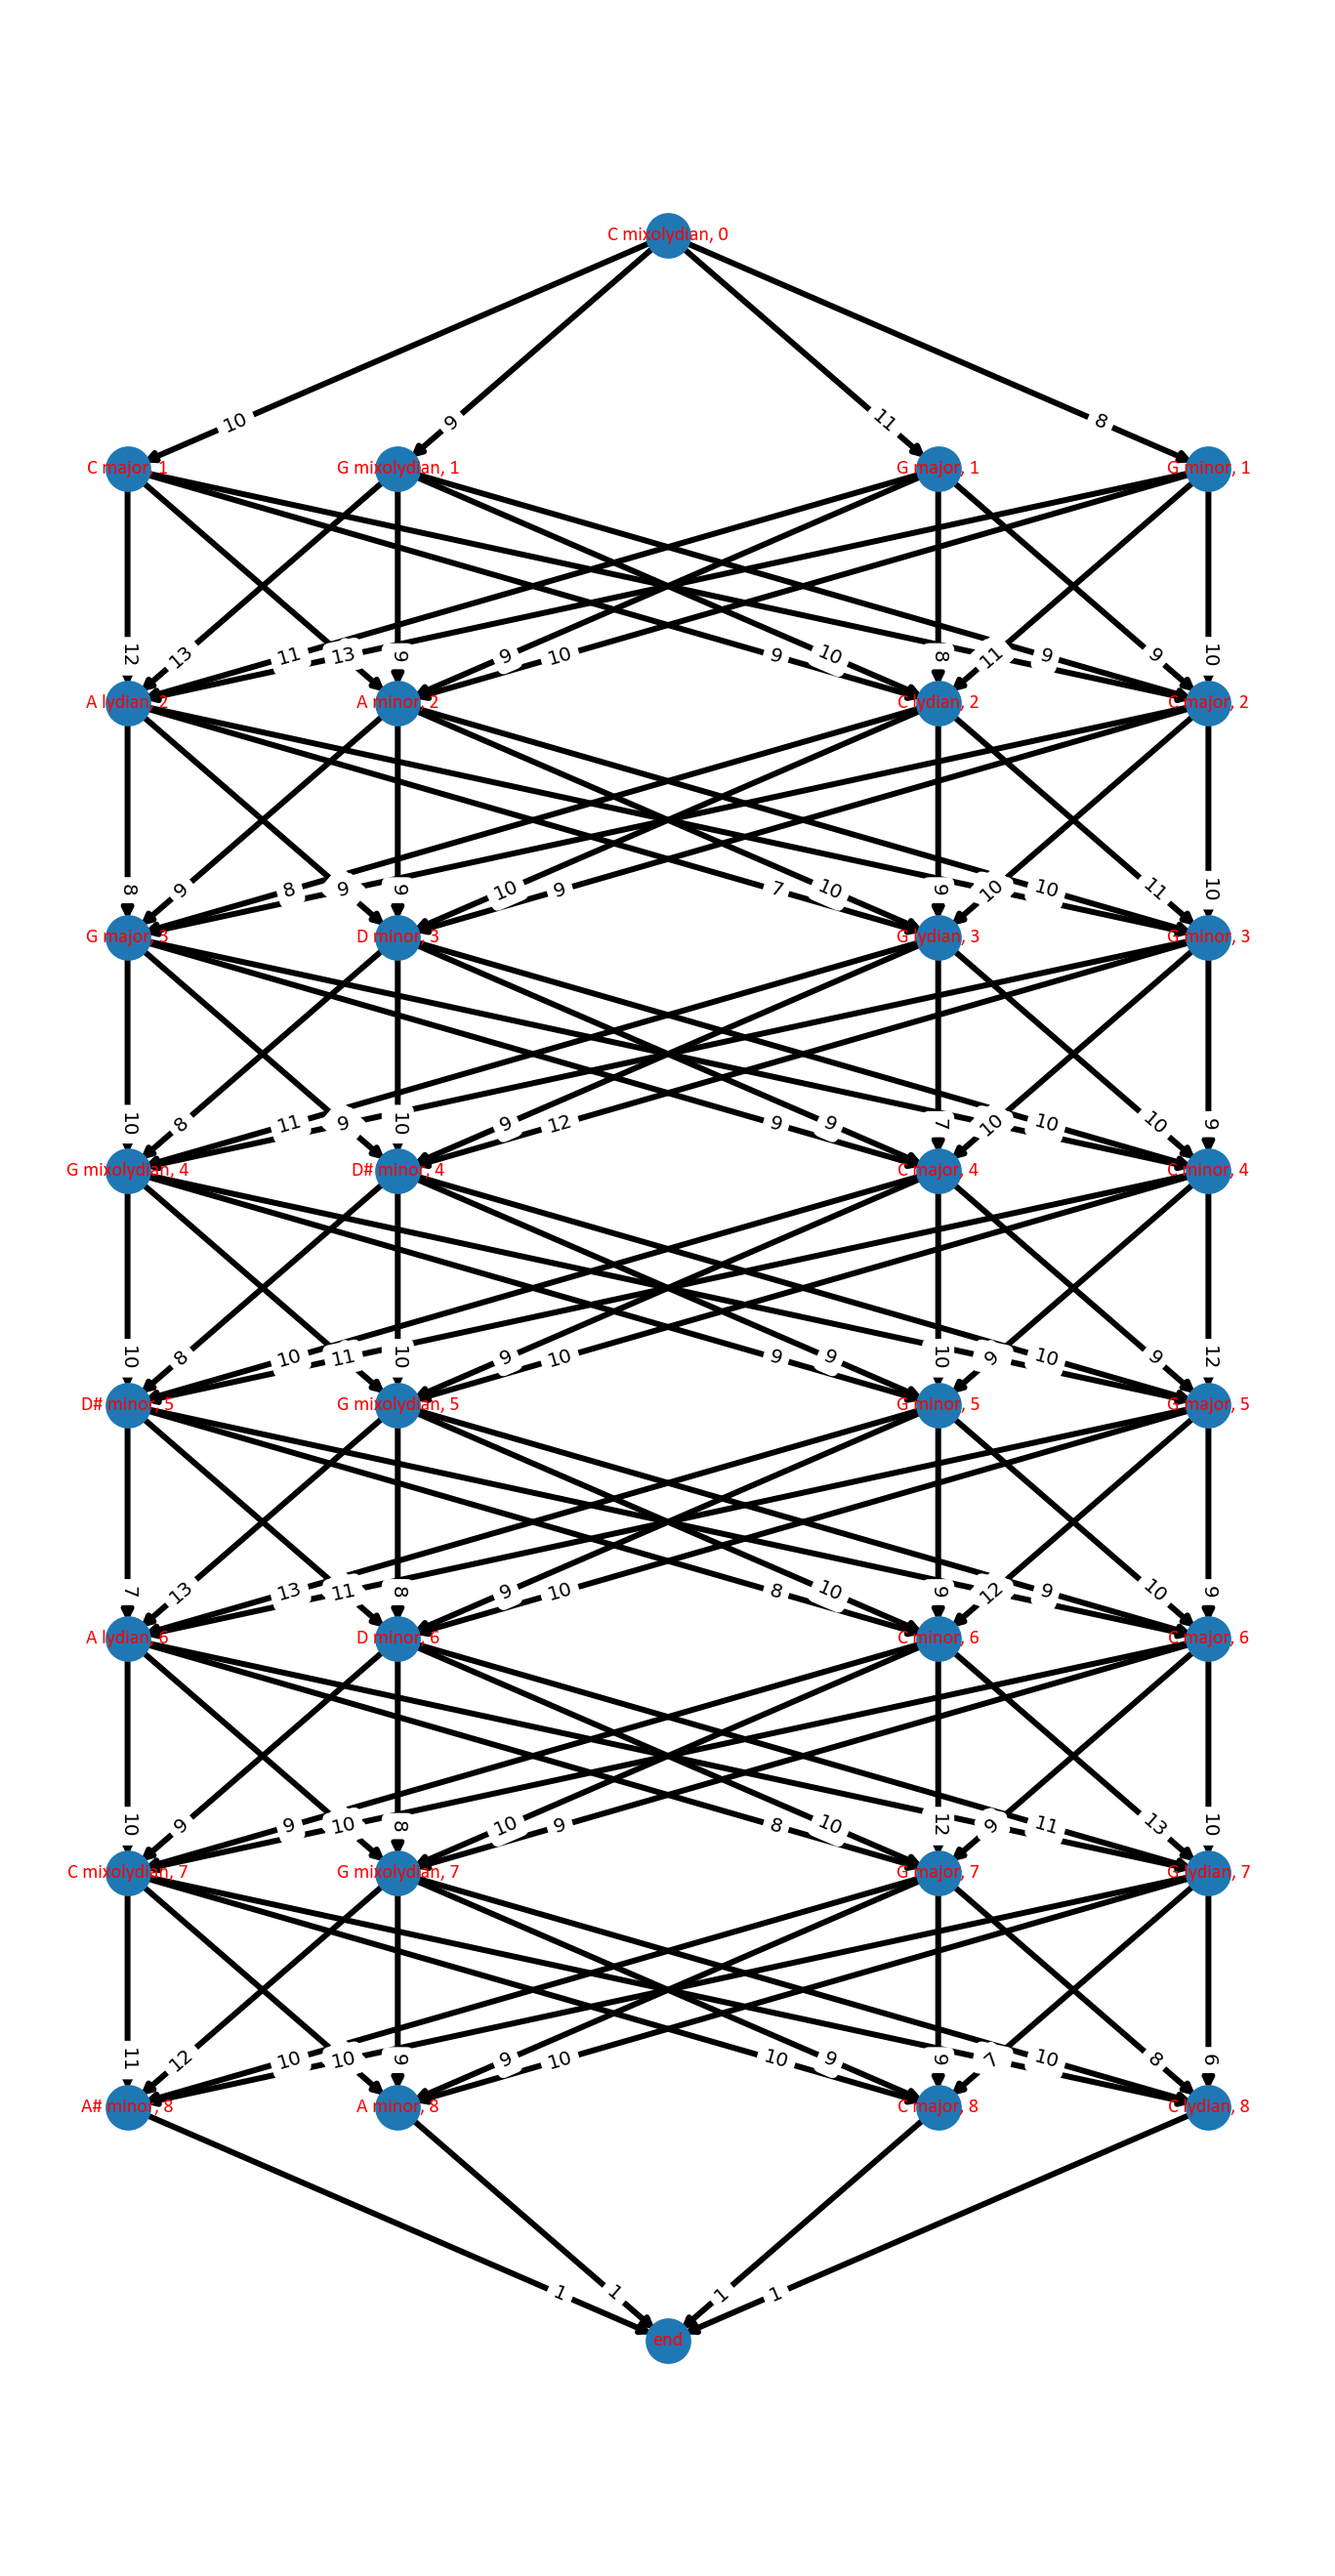

[C mixolydian,
 G minor,
 A minor,
 D minor,
 G mixolydian,
 D# minor,
 A lydian,
 G lydian,
 C lydian]

In [72]:
def calculate_score(a, b):
    """
    Calculates the score between two scales. (See above for the description.)
    a: Scale
    b: Scale
    """
    notesA = a.notes
    notesB = b.notes
    m = 12 - max(1, len(set(notesA) & set(notesB)))
    if b.tonic.name in a.notes:
        m += 3
    return max(0, m)

import sys # for maxsize

def node_name(scale, level):
    return str(scale) + ', ' + str(level)

def scale_from_graph_name(parse):
    first = parse.split(', ')[0]
    note_mode = first.split(' ')
    return palette[palette.index(Scale(note_mode[1], pitch.Pitch('C'), None))].transposed(note_mode[0])

def generate_progression(tonic, levels, n):
    """Generates the progression of Euphoria."""
    # create a dictionary of positions (this will allow a better display in networkx)
    positions = dict()
    # generate the first node
    # I had never noticed that the upperbound was a possible result in Python :') (hence the - 1)
    first_scale = random_scale_from_palette().transposed(tonic)
    # create the graph
    graph = nx.DiGraph()
    # this will be reset at each iteration
    prev_level = [first_scale]
    allLevels = [prev_level]
    positions[node_name(first_scale, 0)] = (0, 0)
    
    fifth = fifth_of(tonic)
    for i in range(1, levels + 1):
        current_level = []
        for k in range(0, n // 2):
            new = None
            # generate a new node
            while new == None or new in current_level:
                if k % 2 == 0:
                    new = random_quasi_diatonic(first_scale)
                else:
                    new = random_scale_from_palette().transposed(random_note())
            current_level.append(new)
            name = node_name(new, i)
            # add the node
            positions[name] = (-(k + 1) * 2, -i)
            graph.add_node(name)
        for k in range(0, n // 2):
            new = None
            # generate a new node
            while new == None or new in current_level:
                new = random_scale_from_palette().transposed(fifth)
            current_level.append(new)
            name = node_name(new, i)
            # add the node
            positions[name] = ((k + 1) * 2, -i)
            graph.add_node(name)
        # connect with the previous level
        for prev in prev_level:
            for curr in current_level:
                graph.add_edge(node_name(prev, i - 1), node_name(curr, i), weight = calculate_score(prev, curr))
        
        allLevels.append(current_level)
        prev_level = current_level
        # switch between tonic and fifth
        if fifth == tonic:
            fifth = fifth_of(tonic)
        else:
            fifth = tonic

    # add the final node
    final_level = "end"
    graph.add_node(final_level)
    positions[final_level] = (0, - levels - 1)
    
    # connect the previous level to the final node
    for e in prev_level:
        graph.add_edge(node_name(e, levels), final_level, weight = 1)
    
    # Apply Dijkstra        
    dj = nx.algorithms.shortest_paths.weighted.dijkstra_path(graph, node_name(first_scale, 0), final_level)
    
    plt.figure(3, figsize=(12, 24))
    # nodes
    nx.draw_networkx_nodes(graph, positions, node_size=500)

    # edges
    nx.draw_networkx_edges(graph, positions, width=3, arrows=True)

    # labels
    nx.draw_networkx_labels(graph, positions, font_size=10, font_family="calibri", font_color="#ff0000")
    weights = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, positions, edge_labels=weights, label_pos=0.2)
    
    plt.axis("off")
    plt.show()
    return dj
path = generate_progression(pitch.Pitch('C'), 8, 4)
[scale_from_graph_name(x) for x in path if x != "end"]

This output is quite satisfactory because it is not just a plain I, IV, V progression, and there is usually at least one surprising chord change. As mentioned in the introduction, we had thought of Markov chains, but they yielded maybe too predictable results, generally speaking, and changing some probabilities just to have something more random didn't make sense; moreover, with our procedure, we have more flexibility as for the scales/modes used and we allow more spontaneous "randomness". We are much more content with this output.

### Melancholy

#### General description

The feeling of melancholy often comes from minor scales and therefore minor chord progressions. 
While many chord progressions help in bringing that melancholic feel, we decided to use the standard II-V-I jazz progression as a basis. 
Therefore, we will leave very little variation for harmonic progression, and we will reserve most of the algorithmic composition for the melodic part. 

This decision stems from the inspiration that chords represent the "background noise" of a day, and therefore keeping the same chord structure ensures
the genericity of a dream: each person has their daily routine, that anchors the dreams into a reality. At the same time, we do not wish our piece to represent any particular night. 


#### Harmonic choices

This part will be strongly inspired by Jazz standards, to the point where we will use their chord grids as a base for our piece.
As most Jazz pieces are written in an **A-A-B-A** format, we will make use of this construction to create a mosaic of music snippets that make sense on their own, yet form a cohesive piece in the end.

We will refer to those "**A's**" and '"**B's**" as Chords Sheet Parts, or CSPs. 
Generally speaking, each CSP provides an introduction, tension, and closure on its own to the sheet, and it is the musician's job to transcend those limits and link the CSPs together.

As mentioned above, we will only use pieces written in minor tonalities to enhance the feel we wish to bring. However, in a very distinctive manner, standards written in minor keys will generally have a **B** CSP in a major key. As we wish to have a dream state be representative of only one emotion, we will mainly focus only using **A** CSPs. 

#### Inspirations
To this date, the list of standards we wish to use in our piece is the following :

- *Autumn Leaves* by Joseph Kosma;
- *Nardis* by Miles Davis;

#### Harmonic and rythmic generative process
The Autumn Leaves' CSPs were chosen to bring a more standard melancholic approach to the problem, and will therefore be reflected both in the probability of appearance as well as their interpretation as such. 

Nardis, by its very chord grid construction, will be mostly used a break point between two Autumn Leaves' parts.

As for the algorithm per se, we will use a Markov chain with given probabilities below:


In [57]:
# Initialize CSP streams.
leavesa = stream.Stream()
leavesb = stream.Stream()
nardisa = stream.Stream()
# Markov chain transition table
trans = {
    leavesa : [[leavesa, leavesb, nardisa], [0.05, 0.35, 0.6]], #While it is best to switch pieces, 
                                                                #the coherence between CSPs leavesa and leavesb allows to have better probability for that transition
    leavesb : [[leavesa, leavesb, nardisa], [0.125, 0.025, 0.85]], #Transitioning back to the same piece after the B CSP is bad, so we heavily decrease such occurences
    nardisa : [[leavesa, leavesb, nardisa], [0.65, 0.2, 0.15]], #Transitioning from an A to a B is decent in itself, so we allow some margin for NardisA to LeavesB.
}

#Algorithm to choose the sequence of CSPs to play. Starting state will always be the A CSP of Autumn Leaves
def csp_chooser(trans, leavesa):
    init_state = leavesa
    chain_length = 4
    piece = []
    for _ in range(chain_length):
        piece.append(init_state)
        next_states, probs = trans[init_state]
        init_state = random.choices(next_states, probs)[0]
    return piece

In [58]:

# Define Nardis A CSP chords
nardisa.append(meter.TimeSignature('4/4'))
# Standard voicings here too
Em7 = chord.Chord('E G B D', quarterLength = 4)
FM7 = chord.Chord('F A C E', quarterLength = 4)
B7 = chord.Chord('B D# F# A', quarterLength = 4)
CM7 = chord.Chord('C E G B', quarterLength = 4)
Am7 = chord.Chord('A C E G', quarterLength = 4)
Dm7 = chord.Chord('D F A C', quarterLength = 4)
EM7= chord.Chord('E G# B D#', quarterLength = 4)

nardisA = [Em7, FM7, B7, CM7, Am7, FM7, EM7, Em7]

# Define Leaves' A and B CSPs chords
leavesa.append(meter.TimeSignature('4/4'))
leavesb.append(meter.TimeSignature('4/4'))
Am7 = chord.Chord('A C E G', quarterLength= 4)
Em7 = chord.Chord('E G B D', quarterLength = 4)
D7 = chord.Chord('C D F# A', quarterLength = 4)
GM7 = chord.Chord('G B D F#', quarterLength = 4)
CM7 = chord.Chord('C E G B', quarterLength = 4)
Gbm7b5 = chord.Chord('F# A C E', quarterLength = 4)# Couldn't name it F#m7b5 bcs of variable naming rules, so I had to resort to Gb
B7 = chord.Chord('B D# F# A', quarterLength = 4)

leavesA = [Am7, D7, GM7, CM7, Gbm7b5, B7, Em7, Em7]
leavesB = [Gbm7b5, B7, Em7, Em7, Am7, D7, GM7, CM7]

# Append chords to corresponding streams.
for i in range(0, 8):
    m = stream.Measure(i)
    n = stream.Measure(i)
    o = stream.Measure(i)
    m.append(nardisA[i])
    n.append(leavesA[i])
    o.append(leavesB[i])
    nardisa.append(m)
    leavesa.append(n)
    leavesb.append(o)

 

#### Melodic choices

As for melodic composition, we will mostly use two scales:

- Minor melodic;
- Minor natural;
- Whole tone scale.

The effect each of those bring is quite unique in their use:

The minor melodic scale will be used for handmade phrases that would individually fit each of the CSP. In our dream approach,this would represent the basis for the real-life events that happened during the day. It anchors the dream in a pseudo-reality that will still match the ambiance of the piece.

The minor natural scale, or Aeolian mode, will be used for randomized phrases, that are made to fit any CSP, and even carry through multiple CSPs if necessary, as all CSPs are in the same tune. Due to its great tension brought by the b6, and having only one 'avoid note', this scale will fit particularly well our piece.

As for the whole tone scale, the idea is to use it with parsimony to induce the utmost dreamlike feeling from times to times. As it is the scale that moves the furthest away from the initial sentiment of this state, its use will be very scarce.

#### Melodic generative process

This part will mostly focus on minor natural and whole tone scales, as all phrases from the minor melodic scale will have been made by hand.

**Minor natural**

With the presence of the b6th, we can create small pockets of tension, that resolve within the next three to four notes. The idea is therefore to create patterns of intervals, alternating between those full of tension, and resolving ones. Using a probablistic approach, we can almost force to have a tense interval (semi-tone between 5th and b6th, b6th-9th, 1st-4th), almost always (see next paragraph) resolving into an interval from the classic triad (with maybe an added 7th, depending on the color we wish to bring). By trying to bring consistency this way, we would also almost surely need that each "pocket" is only ascending or only descending (also for practical purposes on the code). 

In [59]:
# List of patterns used as well as the algorithm used to choose the sequence of patterns in the scale. 
patterns = [(6, 5, 4), (8, 8, 7, 5), (7, 7, 6, 4), (1, 3, 5, 6, 5), (1, 3, 5, 6, 4), (5, 5, 4, 2, 3), (5, 6, 1, 3, 2)]

def phrase_creation(nb_notes):
    """
    Creates a musical phrase of length nb_notes on the minor natural scale and returns a list of integers, 
    representing the degrees of the scale we are to play in succeeding order.
    """
    
    # List of small note patterns we wish to play in the phrase. We will then decide which pattern to play with a probabilistic approach.
    sequence = []
    
    for i in range(0, nb_notes) :
        elem = random.choice(patterns)
        sequence.append(list(elem))
        sequence.append('|')
    
    return sequence

**Minor melodic**

Choosing from a collection of pre-constructed phrases, the algorithm tries to choose a string that fits the next 2-4 chords of the CSP. This algorithm is simple as most of the work is done prior to the generation of the piece.

In [60]:
# List of all phrases for specific CSPs

# Autumn leaves

leaves1 = "theme"
phrase2 = "voice 003"
leaves3 = "la citation"

leavesAphrases = [leaves1, phrase2, leaves3]

leavesb1 = "themeB"
leavesb2 = "impr" #citation made for wesley

leavesBphrases = [leavesb1, phrase2, leavesb2]

nardis1 = "themeN"
nardis2 = "debut solo"
nardis3 = "voice 004"

nardisAphrases = [nardis1, nardis2, nardis3, phrase2]

# Algorithm to choose one phrase that will fit a CSP
def choose_phrase(curr_csp):
    if curr_csp == leavesa:
        return random.choices(leavesAphrases)
    if curr_csp == leavesb:
        return random.choices(leavesBphrases)
    if curr_csp == nardisa:
        return random.choices(nardisAphrases)
    
    

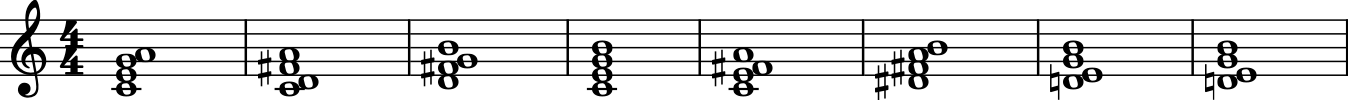

[[5, 5, 4, 2, 3], '|', [1, 3, 5, 6, 5], '|', [1, 3, 5, 6, 5], '|', [8, 8, 7, 5], '|', [1, 3, 5, 6, 4], '|', [5, 5, 4, 2, 3], '|', [8, 8, 7, 5], '|', [6, 5, 4], '|', [8, 8, 7, 5], '|', [8, 8, 7, 5], '|']
['theme']


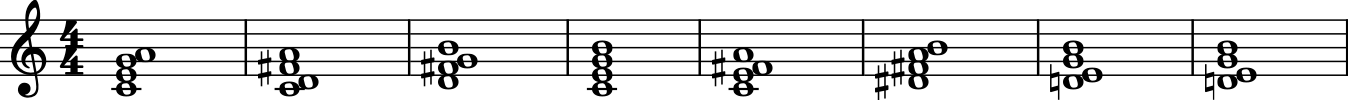

[[8, 8, 7, 5], '|', [5, 5, 4, 2, 3], '|', [6, 5, 4], '|', [6, 5, 4], '|', [6, 5, 4], '|', [5, 5, 4, 2, 3], '|', [1, 3, 5, 6, 5], '|', [6, 5, 4], '|', [5, 6, 1, 3, 2], '|', [7, 7, 6, 4], '|']
['voice 003']


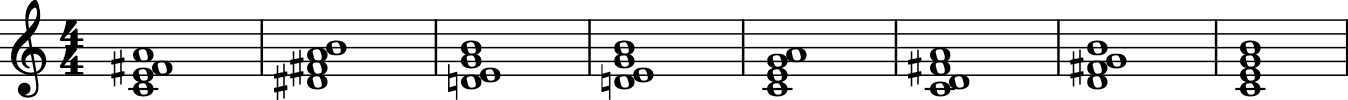

[[6, 5, 4], '|', [8, 8, 7, 5], '|', [1, 3, 5, 6, 5], '|', [7, 7, 6, 4], '|', [8, 8, 7, 5], '|', [8, 8, 7, 5], '|', [5, 5, 4, 2, 3], '|', [7, 7, 6, 4], '|', [5, 5, 4, 2, 3], '|', [1, 3, 5, 6, 4], '|']
['voice 003']


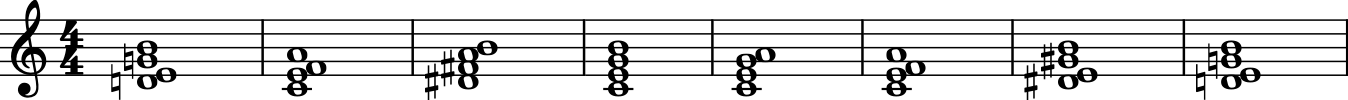

[[6, 5, 4], '|', [5, 5, 4, 2, 3], '|', [5, 5, 4, 2, 3], '|', [8, 8, 7, 5], '|', [7, 7, 6, 4], '|', [1, 3, 5, 6, 5], '|', [1, 3, 5, 6, 5], '|', [6, 5, 4], '|', [8, 8, 7, 5], '|', [1, 3, 5, 6, 4], '|']
['themeN']


In [61]:
# Final piece of code that computes the overall ouput we wish to play.
piece = csp_chooser(trans, leavesa)
for elem in piece:
    elem.show()
    print(phrase_creation(10))
    print(choose_phrase(elem))

### Outroduction

As stated above, this will be the reverse of the audio of the introduction, and, since the motivations had been described earlier, there's not much more to add for this part, in terms of procedure.

### Structure
Here is the generation of the sequence of transitions between the two emotions. The main idea is to come up with a sequence accelerating the transitions, in other words, the duration of each emotion will be shorter as the sequence continues. So we generate this sequence given the parts, their duration (number of measures), the maximum duration of one part and the wanted length of the result sequence.
Basically, at each step of the algorithm, the next duration is randomly chosen between the current maximal duration variable and the current maximal duration variable minus one (*maxDuration - 1* and *maxDuration*), splitting by a quarter. The algorithm runs until the number of desired measures is obtained.

In [62]:
def getDuration(maxDuration):
    """
    Returns a random duration.
    """
    integer = randint(max(maxDuration - 1, 0), maxDuration)
    frac = 0
    if integer != maxDuration or maxDuration == 0:
        frac = randint(0, 3) * 0.25
    return integer + frac

def existOther(nextp, nameOfParts, parts):
    """
    Checks if other parts have remaining measures.
    """
    rest = 0
    for part in parts:
        if part != nextp:
            rest += parts[part]
    return rest != 0

def getNextPart(curr, numberOfParts, nameOfParts, parts):
    """
    Returns the next part to put in the sequence.
    """
    nextp = randint(0, numberOfParts - 1)
    while nextp == curr or parts[nameOfParts[nextp]] == 0:
        nextp = randint(0, numberOfParts - 1)
    return nextp

def generateSequence(parts, maxDuration, total):
    """
    Generates the fully interleft sequence of parts.
    """
    # check arguments
    assert parts != None
    assert maxDuration != None
    assert total != None
    totalDuration = 0
    for part in parts:
        totalDuration += parts[part]
    assert totalDuration - 0.5 >= total
    # define usefull values
    nameOfParts = [name for name in parts]
    numberOfParts = len(nameOfParts)
    # current part (represented by array index)
    curr = randint(0, numberOfParts - 1)
    result = []
    count = 0
    i = 0
    duration = 0
    lastDuration = 0
    # generation
    while count < total:
        # determine the duration of the next measure(s)
        lastDuration = duration
        duration = getDuration(maxDuration)
        while duration == lastDuration or duration == 0:
            duration = getDuration(maxDuration)
        # check that there is enough reamaining measures for current part
        if duration < parts[nameOfParts[curr]]:
            # check if this is only last possibility
            if not existOther(curr, nameOfParts, parts):
                result.append((nameOfParts[curr], total - count))
                return result
            # add section to the result
            result.append((nameOfParts[curr], duration))
            # increment count
            count += duration
            # decrement remaining measures for current part
            parts[nameOfParts[curr]] -= duration
        # select next part
        curr = getNextPart(curr, numberOfParts, nameOfParts, parts)
        # update maxDuration every 3 cycles
        if i % 4 == 0 and maxDuration != 0:
            maxDuration -= 1
        i += 1
    return result

In [63]:
# Part A is euphoria
# Part B is melancholy
parts = {
    "A": 32,
    "B": 32,
}
maxDuration = 6
total = 60 # Here, we put a bit less, so we can just complete with or remove the remainders of parts A and B

sequence = generateSequence(parts, maxDuration, total)
for part in sequence:
    print(part)

('B', 5.75)
('A', 5)
('B', 4.0)
('A', 5)
('B', 4.25)
('A', 3.0)
('B', 3.75)
('A', 4)
('B', 3.5)
('A', 2.0)
('B', 2.75)
('A', 2.25)
('B', 3)
('A', 2)
('B', 1.0)
('A', 1.75)
('B', 1.25)
('A', 1)
('B', 0.75)
('A', 1)
('B', 0.5)
('A', 0.25)
('B', 0.5)
('A', 0.75)
('B', 0.5)
('A', 0.25)
('A', 0.75)


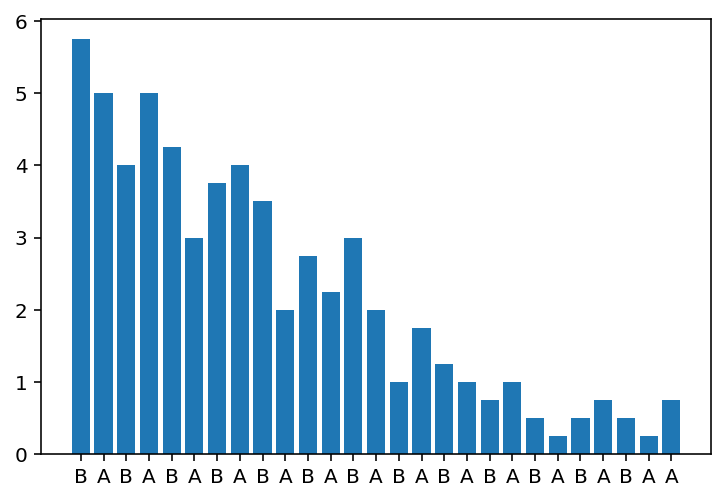

In [64]:
yplot = [part[1] for part in sequence]
xAxis = [part[0] for part in sequence]
xValue = np.arange(len(xAxis))
plt.bar(xValue, yplot)
plt.xticks(xValue, xAxis)
plt.show()

Above, you can see a visualisation of the output of the algorithm. We believe it clearly shows the shortening of the interleft parts.

Thank you for reading this! We hope you appreciated the experience.